# Introduction

This notebook tackles [**Playground Series – Season 5, Episode 10: Predicting Road Accident Risk**](https://www.kaggle.com/competitions/playground-series-s5e10).

# Table of Contents

1. [Introduction](#Introduction)  
2. [Data Loading and Overview](#Data-Loading-and-Overview)
3. [Data Visualization](#Data-Visualization)
4. [Examine Original Dataset](#Examine-Original-Dataset)
5. [Dataset Comparison Report](#Dataset-Comparison-Report)
6. [Feature Engineering](#Feature-Engineering)
7. [Prepare Submission](#Prepare-Submission)


# Data Loading and Overview

In [1]:
%pip install --no-binary lightgbm --config-settings=cmake.define.USE_CUDA=ON lightgbm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip -q install -U optuna
%pip -q install optuna-integration[lightgbm]


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# --- Standard library
import os
import sys
import random
import warnings
from pathlib import Path
from contextlib import contextmanager
from time import time

# --- Third-party
import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice,
    plot_edf,
)
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pandas.api.types import (
    is_categorical_dtype,
    is_numeric_dtype,
    is_object_dtype,
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score, RandomizedSearchCV
from sklearn import set_config
set_config(transform_output="pandas")
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm
import lightgbm as lgbm
import xgboost as xgb

# --- Notebook settings
warnings.filterwarnings("ignore")

# Suppress XGBoost warnings about mismatched devices and tree methods.
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost.core')

%matplotlib inline

In [4]:
# Define some utilities functions
def configure_notebook(seed: int = 10301, float_precision: int = 3, max_columns: int = 15, max_rows: int = 25) -> int:
    """
    Configure notebook settings:
      - Disables warnings for cleaner output.
      - Sets pandas display options for better table formatting.
      - Returns a seed value for reproducibility.
    
    Parameters:
      seed (int): Random seed (default 548).
      float_precision (int): Number of decimal places for floats (default 3).
      max_columns (int): Maximum number of columns to display (default 15).
      max_rows (int): Maximum number of rows to display (default 25).

    Returns:
      int: The provided seed.
    """
    # Disable all warnings
    warnings.filterwarnings("ignore")
    
    # Set pandas display options for nicer output
    pd.options.display.float_format = f"{{:,.{float_precision}f}}".format
    pd.set_option("display.max_columns", max_columns)
    pd.set_option("display.max_rows", max_rows)

    # Set seeds for reproducibility in numpy and the standard random module
    np.random.seed(seed)
    random.seed(seed)
    
    return seed

def running_in_kaggle() -> bool:
    """
    Heuristics that are true in Kaggle notebooks:
    - Special directories exist (/kaggle/input, /kaggle/working)
    - Env var KAGGLE_KERNEL_RUN_TYPE is set
    - The kaggle_secrets module is available
    """
    try:
        if os.path.isdir("/kaggle/input") and os.path.isdir("/kaggle/working"):
            return True
        if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
            return True
        import kaggle_secrets  # noqa: F401  (only exists in Kaggle)
        return True
    except Exception:
        return False

# Use a context manager to suppress standard error output
# This is a robust way to handle warnings that bypass Python's warnings module
class SuppressStderr:
    def __enter__(self):
        self.original_stderr = sys.stderr
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stderr.close()
        sys.stderr = self.original_stderr

In [5]:
# Apply configuration and set random seeds for reproducibility
seed = configure_notebook()    

In [6]:
# Configurable flag to control whether GPU is used
USE_GPU = True

def resolve_lgbm_device(use_gpu: bool, X: pd.DataFrame, y: pd.Series,
                        platform_id: int = -1, device_id: int = -1):
    """
    Returns a dict of LightGBM params for the chosen device.
    Tries OpenCL GPU -> CPU.
    """
    if not use_gpu:
        return {"device_type": "cpu", "force_col_wise": True}  # CPU-only hint

    try:
        probe = lgbm.LGBMRegressor(
            n_estimators=10,
            device_type="gpu",
            max_bin=63,
            gpu_platform_id=platform_id, 
            gpu_device_id=device_id,
            verbosity=-1,
        )
        # tiny probe fit to validate the backend works
        _n = min(len(X), 2000)
        probe.fit(X.iloc[:_n], y.iloc[:_n])
        return {"device_type": "gpu", "gpu_platform_id": platform_id, "gpu_device_id": device_id}
    except Exception as e:
        print("OpenCL not available, falling back to CPU:", type(e).__name__, e)

    # Fall back to CPU
    return {"device_type": "cpu", "force_col_wise": True}

In [7]:
def eda_summary(df: pd.DataFrame) -> None:
    """
    Produce a concise, notebook-friendly Exploratory Data Analysis (EDA) summary.

    This utility prints and displays a standard set of diagnostics for a single
    DataFrame to help you quickly understand schema, completeness, and basic
    statistics. It is designed for use in Jupyter/IPython environments.

    The report includes:
      1. **First 5 rows** (transposed for vertical readability).
      2. **DataFrame info** (`df.info()`): dtypes and non-null counts.
      3. **Numeric describe** (`df.describe()`): count/mean/std/min/percentiles/max.
      4. **Categorical describe** (`df.select_dtypes(['object','category']).describe()`),
         or a note if none exist.
      5. **Missing values summary**: a table with per-column missing count and
         percentage of total rows.
      6. **Duplicate rows**: total number of duplicated records (`df.duplicated().sum()`).
      7. **Data types count**: frequency of each dtype in `df.dtypes`.
      8. **Correlation matrix** for numeric columns (if more than one numeric
         column exists), computed with Pearson correlation.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to summarize.

    Returns
    -------
    None
        Displays/prints the EDA sections and returns nothing.
    """
    # 1. Display the first few rows
    print("======== First 5 Rows ========")
    display(df.head().T)
    
    # 2. DataFrame information (data types, non-null counts, etc.)
    print("\n======== DataFrame Info ========")
    df.info()
    
    # 3. Descriptive statistics for numeric columns
    print("\n======== Descriptive Statistics (Numeric Columns) ========")
    display(df.describe().T)
    
    # 4. Descriptive statistics for categorical columns (if any)
    categorical_df = df.select_dtypes(include=['object', 'category'])
    print("\n======== Descriptive Statistics (Categorical Columns) ========")
    if not categorical_df.empty:
        display(categorical_df.describe())
    else:
        print("No categorical columns found.")
    
    # 5. Missing values summary
    print("\n======== Missing Values Summary ========")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_summary = pd.DataFrame({
        "Missing Count": missing,
        "Percentage": missing_percent
    })
    display(missing_summary)
    
    # 6. Count of duplicated rows
    print("\n======== Duplicated Rows ========")
    print(f"Total duplicated rows: {df.duplicated().sum()}")
    
    # 7. Count of each data type
    print("\n======== Data Types Count ========")
    display(df.dtypes.value_counts())
    
    # 8. Correlation matrix for numeric variables (if more than one exists)
    numeric_cols = df.select_dtypes(include=[np.number])
    if numeric_cols.shape[1] > 1:
        print("\n======== Correlation Matrix (Numeric Columns) ========")
        display(numeric_cols.corr())
    else:
        print("\n======== Correlation Matrix ========")
        print("Not enough numeric columns to compute correlation.")
    
    # 9. Value counts for categorical variables with low cardinality
    print("\n======== Value Counts for Categorical Columns (Low Cardinality) ========")
    if not categorical_df.empty:
        for col in categorical_df.columns:
            if df[col].nunique() <= 20:
                print(f"\nValue Counts for '{col}':")
                display(df[col].value_counts())
    else:
        print("No categorical columns found.")


#### Read the training data and display a bit of it

In [8]:
DATA_DIR = Path('/kaggle/input/playground-series-s5e10') if running_in_kaggle() else Path('data')

training_df = pd.read_csv(DATA_DIR / 'train.csv')
training_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.060,35,daylight,rainy,False,True,afternoon,False,True,1,0.130
1,1,urban,4,0.990,35,daylight,clear,True,False,evening,True,True,0,0.350
2,2,rural,4,0.630,70,dim,clear,False,True,morning,True,False,2,0.300
3,3,highway,4,0.070,35,dim,rainy,True,True,morning,False,False,1,0.210
4,4,rural,1,0.580,60,daylight,foggy,False,False,evening,True,False,1,0.560


#### Read the test data and display it

In [9]:
test_df = pd.read_csv(DATA_DIR / 'test.csv')
test_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.340,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.040,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.590,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.950,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.860,35,daylight,clear,True,False,evening,False,True,3


#### Get rid of the 'id' column before examining the data.  Also, it'll confuse training.

In [10]:
training_df.drop('id', axis=1, inplace=True)
training_df.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,urban,2,0.060,35,daylight,rainy,False,True,afternoon,False,True,1,0.130
1,urban,4,0.990,35,daylight,clear,True,False,evening,True,True,0,0.350
2,rural,4,0.630,70,dim,clear,False,True,morning,True,False,2,0.300
3,highway,4,0.070,35,dim,rainy,True,True,morning,False,False,1,0.210
4,rural,1,0.580,60,daylight,foggy,False,False,evening,True,False,1,0.560


In [11]:
# Save a copy with the ID for use later
test_ids = test_df['id'].copy()

test_df.drop('id', axis=1, inplace=True)
test_df.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,highway,2,0.340,45,night,clear,True,True,afternoon,True,True,1
1,urban,3,0.040,45,dim,foggy,True,False,afternoon,True,False,0
2,urban,2,0.590,35,dim,clear,True,False,afternoon,True,True,1
3,rural,4,0.950,35,daylight,rainy,False,False,afternoon,False,False,2
4,highway,2,0.860,35,daylight,clear,True,False,evening,False,True,3


## Exploratory Data Analysis

In [12]:
eda_summary(training_df)

======== First 5 Rows ========


,0,1,2,3,4
road_type,urban,urban,rural,highway,rural
num_lanes,2,4,4,4,1
curvature,0.060,0.990,0.630,0.070,0.580
speed_limit,35,35,70,35,60
lighting,daylight,daylight,dim,dim,daylight
weather,rainy,clear,clear,rainy,foggy
road_signs_present,False,True,False,True,False
public_road,True,False,True,True,False
time_of_day,afternoon,evening,morning,morning,evening
holiday,False,True,True,False,True



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object

,count,mean,std,min,25%,50%,75%,max
num_lanes,"517,754.000",2.492,1.120,1.000,1.000,2.000,3.000,4.000
curvature,"517,754.000",0.489,0.273,0.000,0.260,0.510,0.710,1.000
speed_limit,"517,754.000",46.113,15.789,25.000,35.000,45.000,60.000,70.000
num_reported_accidents,"517,754.000",1.188,0.896,0.000,1.000,1.000,2.000,7.000
accident_risk,"517,754.000",0.352,0.166,0.000,0.230,0.340,0.460,1.000



======== Descriptive Statistics (Categorical Columns) ========


,road_type,lighting,weather,time_of_day
count,517754,517754,517754,517754
unique,3,3,3,3
top,highway,dim,foggy,morning
freq,173672,183826,181463,173410



======== Missing Values Summary ========


,Missing Count,Percentage
road_type,0,0.000
num_lanes,0,0.000
curvature,0,0.000
speed_limit,0,0.000
lighting,0,0.000
weather,0,0.000
road_signs_present,0,0.000
public_road,0,0.000
time_of_day,0,0.000
holiday,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 656

======== Data Types Count ========


object     4
bool       4
int64      3
float64    2
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
num_lanes,1.000,-0.020,0.001,0.018,-0.006
curvature,-0.020,1.000,0.008,0.145,0.544
speed_limit,0.001,0.008,1.000,0.031,0.431
num_reported_accidents,0.018,0.145,0.031,1.000,0.214
accident_risk,-0.006,0.544,0.431,0.214,1.000



======== Value Counts for Categorical Columns (Low Cardinality) ========

Value Counts for 'road_type':


road_type
highway    173672
rural      172719
urban      171363
Name: count, dtype: int64


Value Counts for 'lighting':


lighting
dim         183826
daylight    178015
night       155913
Name: count, dtype: int64


Value Counts for 'weather':


weather
foggy    181463
clear    179306
rainy    156985
Name: count, dtype: int64


Value Counts for 'time_of_day':


time_of_day
morning      173410
evening      172837
afternoon    171507
Name: count, dtype: int64

#### Show the statistics and structure of the test data

In [13]:
eda_summary(test_df)

======== First 5 Rows ========


,0,1,2,3,4
road_type,highway,urban,urban,rural,highway
num_lanes,2,3,2,4,2
curvature,0.340,0.040,0.590,0.950,0.860
speed_limit,45,45,35,35,35
lighting,night,dim,dim,daylight,daylight
weather,clear,foggy,clear,rainy,clear
road_signs_present,True,True,True,False,True
public_road,True,False,False,False,False
time_of_day,afternoon,afternoon,afternoon,afternoon,evening
holiday,True,True,True,False,False



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               172585 non-null  object 
 1   num_lanes               172585 non-null  int64  
 2   curvature               172585 non-null  float64
 3   speed_limit             172585 non-null  int64  
 4   lighting                172585 non-null  object 
 5   weather                 172585 non-null  object 
 6   road_signs_present      172585 non-null  bool   
 7   public_road             172585 non-null  bool   
 8   time_of_day             172585 non-null  object 
 9   holiday                 172585 non-null  bool   
 10  school_season           172585 non-null  bool   
 11  num_reported_accidents  172585 non-null  int64  
dtypes: bool(4), float64(1), int64(3), object(4)
memory usage: 11.2+ MB

======== Descriptive Stati

,count,mean,std,min,25%,50%,75%,max
num_lanes,"172,585.000",2.494,1.119,1.000,1.000,2.000,3.000,4.000
curvature,"172,585.000",0.487,0.272,0.000,0.260,0.510,0.710,1.000
speed_limit,"172,585.000",46.103,15.787,25.000,35.000,45.000,60.000,70.000
num_reported_accidents,"172,585.000",1.186,0.897,0.000,1.000,1.000,2.000,7.000



======== Descriptive Statistics (Categorical Columns) ========


,road_type,lighting,weather,time_of_day
count,172585,172585,172585,172585
unique,3,3,3,3
top,highway,dim,foggy,morning
freq,58080,61143,60236,57747



======== Missing Values Summary ========


,Missing Count,Percentage
road_type,0,0.000
num_lanes,0,0.000
curvature,0,0.000
speed_limit,0,0.000
lighting,0,0.000
weather,0,0.000
road_signs_present,0,0.000
public_road,0,0.000
time_of_day,0,0.000
holiday,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 1203

======== Data Types Count ========


object     4
bool       4
int64      3
float64    1
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,num_lanes,curvature,speed_limit,num_reported_accidents
num_lanes,1.000,-0.021,0.002,0.017
curvature,-0.021,1.000,0.006,0.143
speed_limit,0.002,0.006,1.000,0.030
num_reported_accidents,0.017,0.143,0.030,1.000



======== Value Counts for Categorical Columns (Low Cardinality) ========

Value Counts for 'road_type':


road_type
highway    58080
rural      57409
urban      57096
Name: count, dtype: int64


Value Counts for 'lighting':


lighting
dim         61143
daylight    59397
night       52045
Name: count, dtype: int64


Value Counts for 'weather':


weather
foggy    60236
clear    59982
rainy    52367
Name: count, dtype: int64


Value Counts for 'time_of_day':


time_of_day
morning      57747
evening      57629
afternoon    57209
Name: count, dtype: int64

# Data Visualization

#### Target & Feature distributions — What & why
We first examine the distribution of **accident_risk** and the marginal distributions of key numeric features.
This reveals central tendency, spread, skewness, and potential multi‑modality (e.g., half/double‑time clusters).
These insights inform scaling and simple transforms and guard against outlier‑driven RMSE errors.

In [14]:
def detect_target(df: pd.DataFrame):
    """
    Infer the target column name from common candidates.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame to inspect.

    Returns
    -------
    str
        The name of the detected target column.

    Raises
    ------
    KeyError
        If none of the candidate names are present in ``df`` columns.
    """
    candidates = ["accident_risk", "AccidentRisk"]
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError("Could not detect target column. Set `target_col` manually.")

def numeric_features(df: pd.DataFrame, exclude=None) -> list[str]:
    """
    Return numeric feature column names, optionally excluding some.

    Uses ``DataFrame.select_dtypes(include="number")`` to find numeric dtypes
    (e.g., int, float; typically excludes booleans), then removes any names
    provided in ``exclude``.

    Parameters
    ----------
    df : pandas.DataFrame
        Source DataFrame.
    exclude : iterable of str or None, optional
        Column names to exclude from the result. Defaults to ``None``.

    Returns
    -------
    list of str
        Ordered list of numeric feature column names present in ``df`` and
        not listed in ``exclude``.
    """
    exclude = set(exclude or [])
    return [c for c in df.select_dtypes(include="number").columns if c not in exclude]

def safe_sample(df: pd.DataFrame, n: int = 200_000, seed: int = seed) -> pd.DataFrame:
    """
    Return a sample of up to ``n`` rows without replacement; if ``df`` has
    ``<= n`` rows, return it unchanged.

    This is a convenience helper for large datasets—useful to keep quick EDA
    cells responsive while remaining deterministic via ``seed``.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame.
    n : int, optional
        Maximum number of rows to return. Default is ``200_000``.
    seed : int, optional
        Random seed for reproducibility (passed to ``random_state``). Default ``seed``.

    Returns
    -------
    pandas.DataFrame
        A sampled view of ``df`` with at most ``n`` rows, or ``df`` itself if
        it already has ``<= n`` rows.
    """
    if len(df) > n:
        return df.sample(n, random_state=seed)
    return df

def describe_df(df: pd.DataFrame):
    """
    Summarize a modeling DataFrame as (target, numeric_features).

    Detects the target column via :func:`detect_target`, then returns the target
    name and the list of numeric feature columns excluding that target.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame expected to contain a recognizable target column.

    Returns
    -------
    (str, list of str)
        A 2-tuple ``(target_name, numeric_feature_names)``.

    Raises
    ------
    KeyError
        Propagated from :func:`detect_target` if no target column is found.
    """
    target = detect_target(df)
    nums   = numeric_features(df, exclude=[target])
    return target, nums

In [15]:
def plot_target_distribution(df: pd.DataFrame, target:str) :
    """
    Plot a histogram of a target column in a DataFrame.

    Computes the number of bins as ``max(20, floor(sqrt(N)))`` where ``N`` is the
    number of rows, then renders a simple histogram using Matplotlib. The plot is
    titled with the target name and labeled on both axes.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the target column.
    target : str
        Name of the target column in ``df``.

    Returns
    -------
    None
        Displays the histogram and returns nothing.

    Raises
    ------
    KeyError
        If ``target`` is not a column in ``df``.
    """
    plt.figure(figsize=(8,5))
    x = df[target].to_numpy()
    bins = max(20, int(np.sqrt(len(x))))
    plt.hist(x, bins=bins, edgecolor="black")
    plt.title(f"{target} Distribution")
    plt.xlabel(target)
    plt.ylabel("Count")
    plt.show()

In [16]:
def plot_feature_distributions(df: pd.DataFrame, num: list[str]) :
    """
    Plot histograms for a prioritized subset of numeric features.

    Given a list of candidate numeric columns, the function selects features
    using a case-insensitive priority list:
    {"energy", "audioloudness", "vocalscore", "vocalcontent", "instrumentalscore",
     "rhythmscore", "acousticquality", "moodscore", "trackdurationms"}.
    If none of the provided names match the priority set, it falls back to the
    first eight names in ``num``.

    For each selected feature, missing values are dropped, an appropriate number
    of bins is chosen as ``max(20, floor(sqrt(N)))``, and a histogram is rendered
    with axis labels and a title.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the candidate feature columns.
    num : list of str
        Names of numeric columns to consider. The function will plot up to eight
        of these, prioritizing the canonical feature names listed above.

    Returns
    -------
    None
        Displays one histogram per selected feature and returns nothing.

    Raises
    ------
    KeyError
        If any selected column name is not present in ``df``.
    TypeError
        If a selected column is non-numeric and cannot be histogrammed.
    """
    priority = {
        "energy", "audioloudness", "vocalscore", "vocalcontent", "instrumentalscore",
        "rhythmscore", "acousticquality", "moodscore", "trackdurationms"
    }
    
    top_view = [c for c in num if c.lower() in priority]
    if not top_view:
        top_view = num[:8]  # fallback

    for col in top_view:
        vals = df[col].dropna().to_numpy()
        if len(vals) == 0:
            continue
            
        plt.figure(figsize=(8,4))
        bins = max(20, int(np.sqrt(len(vals))))
        plt.hist(vals, bins=bins, edgecolor="black")
        plt.title(f"{col} Distribution")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

In [17]:
def plot_feature_target_relationships(df: pd.DataFrame, target:str, num: list[str]):
    """
    Plot hexbin relationships between selected features and the target.

    The function first subsamples up to 200,000 rows (via ``safe_sample``) from
    the columns ``[target] + num`` for responsiveness. It then checks a
    canonical, case-sensitive list of feature→target pairs:

        ("AudioLoudness", target),
        ("Energy", target),
        ("VocalContent", target),
        ("InstrumentalScore", target),
        ("RhythmScore", target),
        ("TrackDurationMs", target)

    Any pair whose columns are present in the sampled DataFrame is plotted as a
    hexbin density scatter with a count colorbar.

    Parameters
    ----------
    df : pandas.DataFrame
        Source DataFrame containing the target and candidate feature columns.
    target : str
        Name of the target column in ``df`` (must be numeric for hexbin).
    num : list of str
        Candidate numeric feature column names. Used to subset the DataFrame
        before plotting (for performance) and to ensure the target is present.

    Returns
    -------
    None
        Displays one hexbin plot per valid (feature, target) pair and returns nothing.

    Raises
    ------
    KeyError
        If any of the columns in ``[target] + num`` are not present in ``df``.
    TypeError or ValueError
        If a plotted column contains non-numeric data incompatible with hexbin.
    """
    sampled = safe_sample(df[[target] + num], n=200_000)

    pairs_to_check = [
        ("num_lanes", target),
        ("curvature", target),
        ("speed_limit", target),
        ("num_reported_accidents", target),
    ]
    pairs_to_check = [(x,y) for x,y in pairs_to_check if x in sampled.columns and y in sampled.columns]

    for x, y in pairs_to_check:
        plt.figure(figsize=(7,6))
        hb = plt.hexbin(sampled[x], sampled[y], gridsize=40, mincnt=1)
        plt.xlabel(x); plt.ylabel(y); plt.title(f"{x} vs. {y} (hexbin)")
        cb = plt.colorbar(hb); cb.set_label("count")
        plt.show()

In [18]:
def plot_missing_values(df: pd.DataFrame):
    """
    Visualize the count of missing values per column as a horizontal bar chart.

    Computes per-column NA counts, filters out columns with zero missing values,
    and plots a horizontal bar chart sorted by descending count. If the DataFrame
    has no missing values, a message is printed instead of plotting.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to analyze for missing values.

    Returns
    -------
    None
        Displays the plot (if any) and returns nothing.
    """
    na_counts = df.isna().sum().sort_values(ascending=False)
    na_counts = na_counts[na_counts > 0]
    if len(na_counts):
        plt.figure(figsize=(8, max(3, len(na_counts)*0.35)))
        plt.barh(na_counts.index.astype(str), na_counts.values)
        plt.title("Missing Values per Column")
        plt.xlabel("Count")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
    else:
        print("No missing values detected.")

In [19]:
# Show top non-trivial pairs
def top_pairs(corr: pd.Series, k: int = 10):
    """
    Return the top-k strongest (absolute) pairwise correlations from an unstacked correlation Series.

    Expects a Series whose index is a 2-level MultiIndex ``(col_i, col_j)`` and whose
    values are correlation coefficients (usually absolute values), e.g. produced by
    ``df.corr().abs().unstack()``. Self-pairs and symmetric duplicates are removed
    by keeping only entries where ``col_i < col_j``.

    Parameters
    ----------
    corr : pandas.Series
        Series with MultiIndex pairs and correlation values.
    k : int, optional
        Number of top pairs to return. Default is ``10``.

    Returns
    -------
    list of (Hashable, Hashable, float)
        A list of ``(col_i, col_j, value)`` tuples sorted by descending ``value``,
        containing only non-trivial, unique pairs.
    """
    pairs = [(a,b,v) for (a,b),v in corr.items() if a<b]
    return sorted(pairs, key=lambda x: x[2], reverse=True)[:k]

def show_relationship_rank(df: pd.DataFrame):
    """
    Compute and return the strongest pairwise relationships among numeric columns
    using both Pearson (linear) and Spearman (rank/monotonic) correlations.

    The function:
      1) Selects numeric columns via ``df.select_dtypes(include="number")``.
      2) Computes absolute-valued Pearson and Spearman correlation matrices.
      3) Unstacks each matrix to a long Series of ``(col_i, col_j) -> score``.
      4) Summarizes with ``top_pairs(...)`` to keep only unique, non-trivial
         pairs (no self-pairs, no symmetric duplicates) sorted by descending score.
         By default, ``top_pairs`` returns the top 10 pairs for each metric.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing candidate numeric features.

    Returns
    -------
    Tuple[List[Tuple[Hashable, Hashable, float]], List[Tuple[Hashable, Hashable, float]]]
        ``(pearson_top, spearman_top)`` where each element is a list of
        ``(col_i, col_j, score)`` tuples, sorted by descending ``score``.
    """
    num = df.select_dtypes(include="number")
    pearson_top = num.corr().abs().unstack().sort_values(ascending=False)
    spearman_top = num.corr(method="spearman").abs().unstack().sort_values(ascending=False)
    return top_pairs(pearson_top), top_pairs(spearman_top)


### Find the target column

In [20]:
t_target, t_num = describe_df(training_df)
print(f"Detected target: {t_target}")
print(f"Numeric features (excluding target): {len(t_num)} columns")

Detected target: accident_risk
Numeric features (excluding target): 4 columns


### Target distribution (accident_risk)

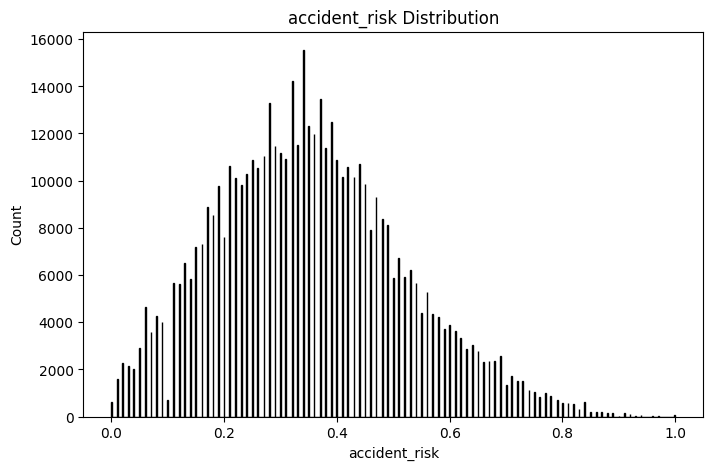

In [21]:
plot_target_distribution(training_df, t_target)

The **BeatsPerMinute** histogram shows a broad spread typical of mixed genres, with the bulk of tracks sitting in the common musical range (roughly moderato to allegro). You may notice mild clustering around tempo “equivalents” (e.g., ~60 and ~120 BPM) due to human perception and annotation habits—double/half-time interpretations often create secondary peaks. The tail behavior looks well-behaved (few extreme outliers), which is good news for RMSE.

**Modeling takeaway:** Because RMSE punishes large errors, watch for octave (×2/÷2) mistakes; a simple tempo-equivalence post-check (e.g., comparing predictions against ½×/2× variants) can reduce those.


### Feature distributions

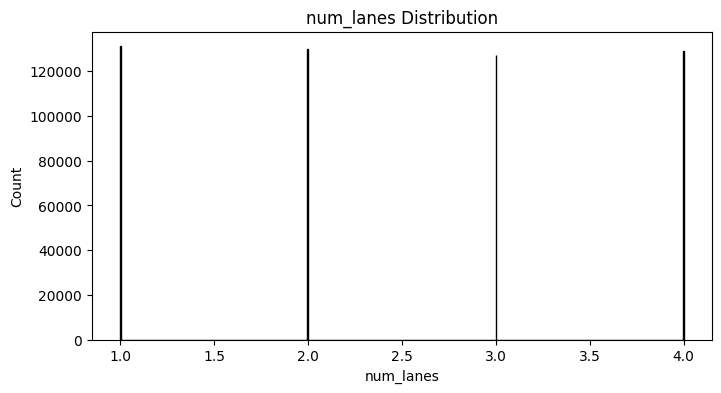

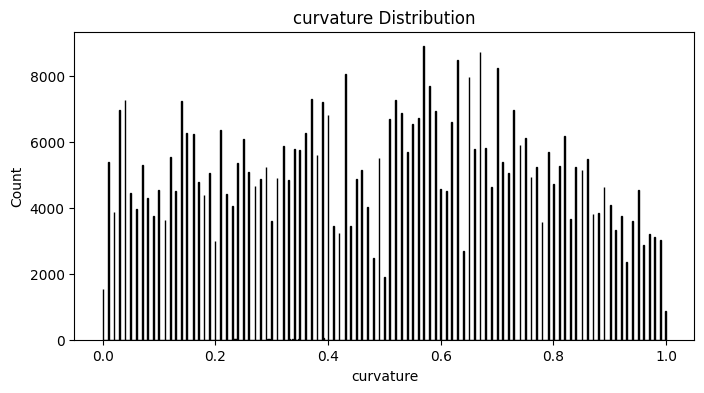

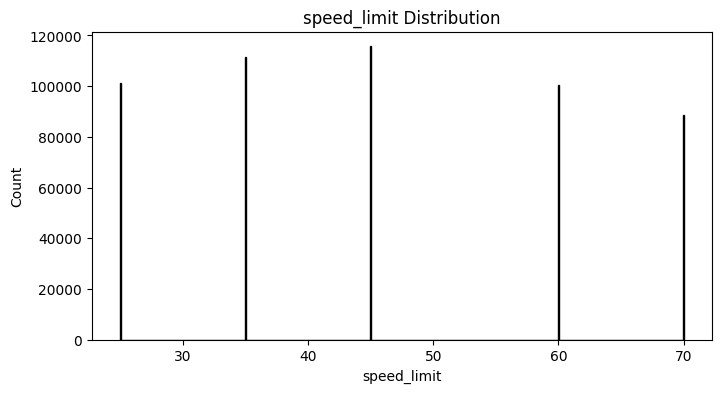

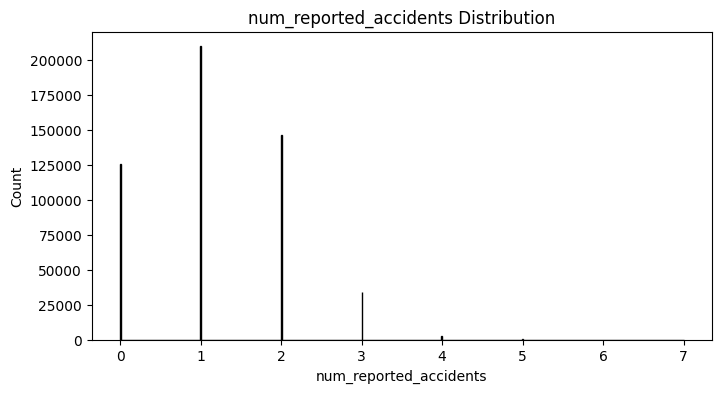

In [22]:
plot_feature_distributions(training_df, t_num)

**TODO** Analysis of feature distribution plots.

### Feature ↔ target relationships (hexbin)

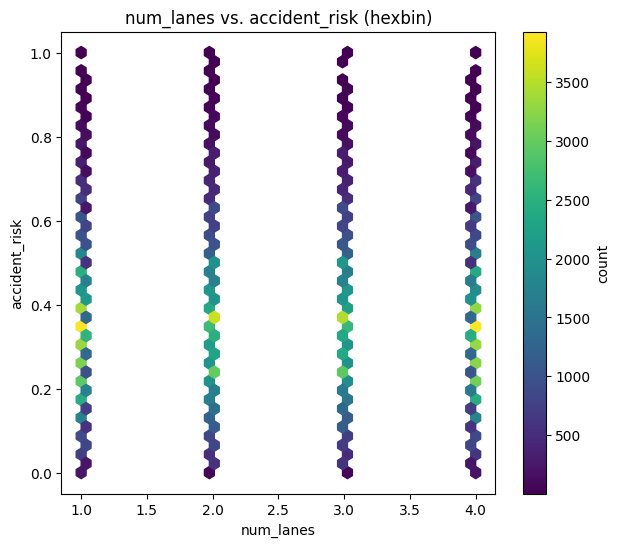

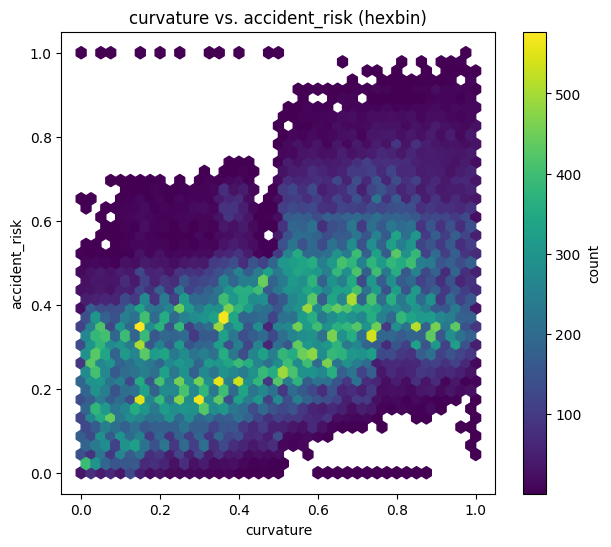

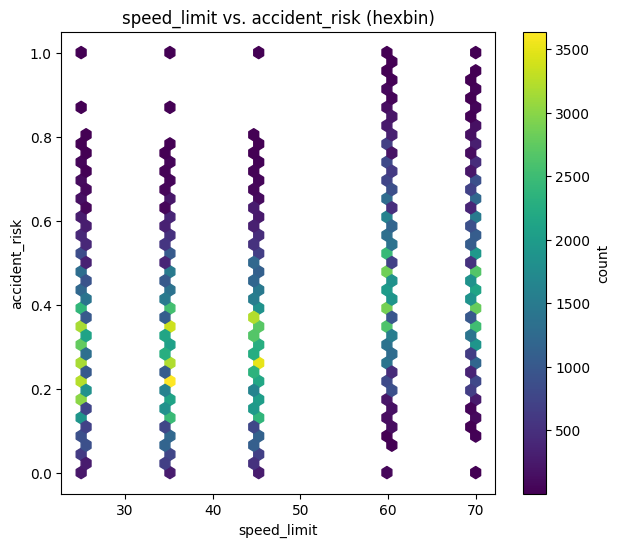

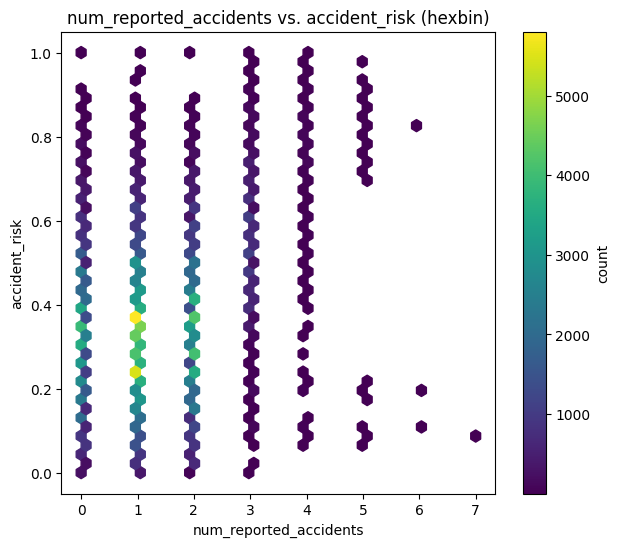

In [23]:
plot_feature_target_relationships(training_df, t_target, t_num)

Hexbin plots make the dense regions readable:

* **TODO:** Write analysis.

## Missing values overview

In [24]:
plot_missing_values(training_df)

No missing values detected.


The notebook reports **No missing values detected.** That simplifies the pipeline—no imputation branch is needed.
    
**Modeling takeaway:** We can keep preprocessing lean; just ensure identical scaling/encoding is applied to train and test.

### Rank relationships numerically

In [25]:
show_relationship_rank(training_df)

([('accident_risk', 'curvature', 0.5439459306735055),
  ('accident_risk', 'speed_limit', 0.43089799710043036),
  ('accident_risk', 'num_reported_accidents', 0.2138909159484056),
  ('curvature', 'num_reported_accidents', 0.14503382046145502),
  ('num_reported_accidents', 'speed_limit', 0.03137280025429883),
  ('curvature', 'num_lanes', 0.020245158363362457),
  ('num_lanes', 'num_reported_accidents', 0.017662427910798327),
  ('curvature', 'speed_limit', 0.008398810129057663),
  ('accident_risk', 'num_lanes', 0.00600338323960131),
  ('num_lanes', 'speed_limit', 0.0011944213352690256)],
 [('accident_risk', 'curvature', 0.5467742572109716),
  ('accident_risk', 'speed_limit', 0.4091443727659698),
  ('accident_risk', 'num_reported_accidents', 0.15426290391341518),
  ('curvature', 'num_reported_accidents', 0.11775043180338708),
  ('num_reported_accidents', 'speed_limit', 0.022229346656738435),
  ('curvature', 'num_lanes', 0.020277743956126127),
  ('num_lanes', 'num_reported_accidents', 0.01534

Correlation ranking among numeric features highlights where information overlaps (Pearson on the left, Spearman on the right). Your top pairs:
* **AcousticQuality ↔ Energy**: **0.418** (Pearson) / **0.440** (Spearman) — strongest overall; potential redundancy/interaction.
* **Energy ↔ LivePerformanceLikelihood**: **0.266** / **0.281** — moderate alignment.
* **Energy ↔ MoodScore**: **0.242** / **0.230** — modest positive link.
* **AudioLoudness ↔ Energy**: **0.192** / **0.203** — weak–moderate.
* **Energy ↔ RhythmScore**: **0.147** / **0.165** — weak–moderate.
* **LivePerformanceLikelihood ↔ VocalContent**: **0.120** / **0.156** — weak–moderate.
* Others (e.g., **Energy ↔ TrackDurationMs** ~**0.049** Pearson; **Energy ↔ InstrumentalScore** ~**0.043** Spearman) are **weak**.

**Modeling takeaway:** Correlations are **not high** (≤ ~0.44), which is good—features are not collinear clones. Still, the **Energy cluster** (Energy with AcousticQuality/Loudness/Rhythm/Mood) suggests trying either (a) a tree/boosting model that naturally captures these interactions, or (b) a linear model with a small set of engineered interaction terms. Regularization (L1/L2/ElasticNet) will guard against overfit.

## Examine Original Dataset

This challenge is based on the [**BPM Prediction Challenge**](https://www.kaggle.com/datasets/gauravduttakiit/bpm-prediction-challenge) dataset.  Let's examine this dataset to see if the current dataset differs.

In [26]:
ORIGINAL_DIR = Path("/kaggle/input/simulated-roads-accident-data") if running_in_kaggle() else Path("original_data")

original_df = pd.read_csv(ORIGINAL_DIR / 'synthetic_road_accidents_100k.csv')
original_df

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,rural,2,0.290,70,night,rainy,False,True,evening,False,False,1,0.640
1,highway,1,0.340,25,dim,clear,False,False,morning,False,False,3,0.270
2,rural,2,0.760,70,night,foggy,True,False,evening,True,True,1,0.760
3,rural,3,0.370,70,night,foggy,True,False,morning,False,True,0,0.600
4,highway,3,0.390,45,dim,rainy,False,True,morning,False,False,0,0.170
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,rural,2,0.610,60,dim,foggy,False,True,evening,False,False,1,0.540
99996,rural,2,0.520,35,dim,foggy,True,True,afternoon,False,False,1,0.180
99997,rural,2,0.080,70,daylight,clear,False,False,evening,True,False,1,0.200
99998,rural,1,0.830,70,dim,foggy,False,True,morning,False,True,0,0.580


In [27]:
eda_summary(original_df)

======== First 5 Rows ========


,0,1,2,3,4
road_type,rural,highway,rural,rural,highway
num_lanes,2,1,2,3,3
curvature,0.290,0.340,0.760,0.370,0.390
speed_limit,70,25,70,70,45
lighting,night,dim,night,night,dim
weather,rainy,clear,foggy,foggy,rainy
road_signs_present,False,False,True,True,False
public_road,True,False,False,False,True
time_of_day,evening,morning,evening,morning,morning
holiday,False,False,True,False,False



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               100000 non-null  object 
 1   num_lanes               100000 non-null  int64  
 2   curvature               100000 non-null  float64
 3   speed_limit             100000 non-null  int64  
 4   lighting                100000 non-null  object 
 5   weather                 100000 non-null  object 
 6   road_signs_present      100000 non-null  bool   
 7   public_road             100000 non-null  bool   
 8   time_of_day             100000 non-null  object 
 9   holiday                 100000 non-null  bool   
 10  school_season           100000 non-null  bool   
 11  num_reported_accidents  100000 non-null  int64  
 12  accident_risk           100000 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(

,count,mean,std,min,25%,50%,75%,max
num_lanes,"100,000.000",2.495,1.118,1.000,1.000,2.000,3.000,4.000
curvature,"100,000.000",0.501,0.289,0.000,0.250,0.500,0.750,1.000
speed_limit,"100,000.000",47.055,16.322,25.000,35.000,45.000,60.000,70.000
num_reported_accidents,"100,000.000",1.503,1.229,0.000,1.000,1.000,2.000,10.000
accident_risk,"100,000.000",0.383,0.179,0.000,0.250,0.380,0.510,1.000



======== Descriptive Statistics (Categorical Columns) ========


,road_type,lighting,weather,time_of_day
count,100000,100000,100000,100000
unique,3,3,3,3
top,urban,dim,clear,morning
freq,33449,33562,33511,33374



======== Missing Values Summary ========


,Missing Count,Percentage
road_type,0,0.000
num_lanes,0,0.000
curvature,0,0.000
speed_limit,0,0.000
lighting,0,0.000
weather,0,0.000
road_signs_present,0,0.000
public_road,0,0.000
time_of_day,0,0.000
holiday,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 28

======== Data Types Count ========


object     4
bool       4
int64      3
float64    2
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
num_lanes,1.000,-0.003,0.001,0.004,0.002
curvature,-0.003,1.000,-0.001,0.002,0.480
speed_limit,0.001,-0.001,1.000,-0.002,0.494
num_reported_accidents,0.004,0.002,-0.002,1.000,0.171
accident_risk,0.002,0.480,0.494,0.171,1.000



======== Value Counts for Categorical Columns (Low Cardinality) ========

Value Counts for 'road_type':


road_type
urban      33449
highway    33424
rural      33127
Name: count, dtype: int64


Value Counts for 'lighting':


lighting
dim         33562
night       33251
daylight    33187
Name: count, dtype: int64


Value Counts for 'weather':


weather
clear    33511
foggy    33274
rainy    33215
Name: count, dtype: int64


Value Counts for 'time_of_day':


time_of_day
morning      33374
afternoon    33354
evening      33272
Name: count, dtype: int64

In [28]:
target_col, num_cols = describe_df(original_df)
o_target, o_num = describe_df(original_df)

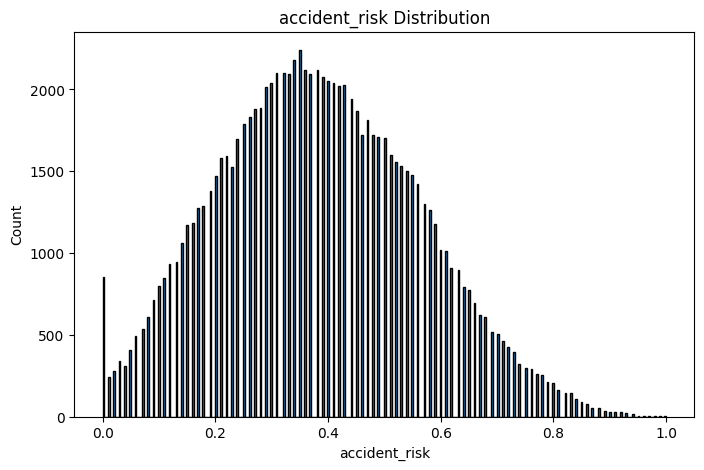

In [29]:
plot_target_distribution(original_df, o_target)

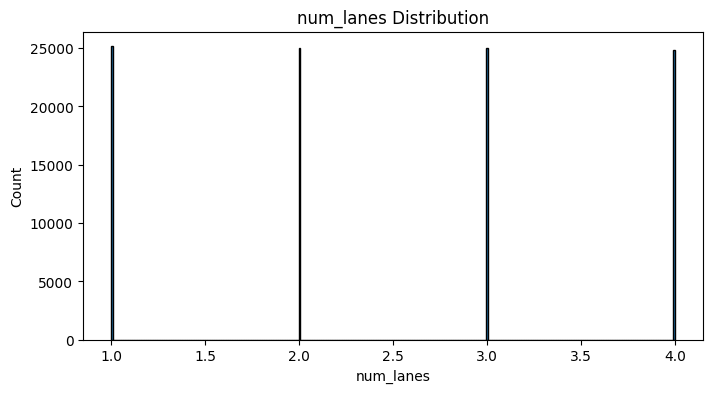

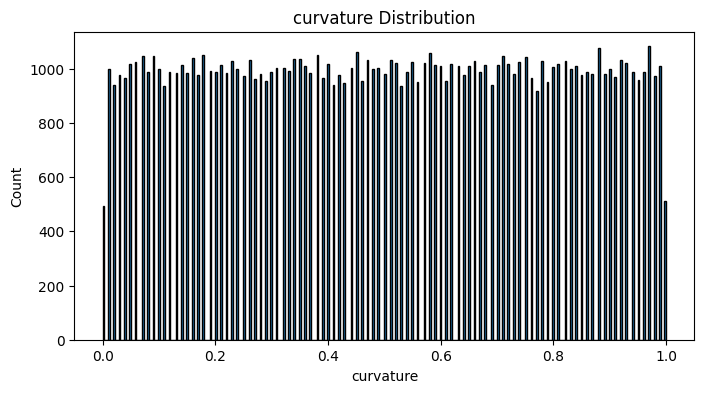

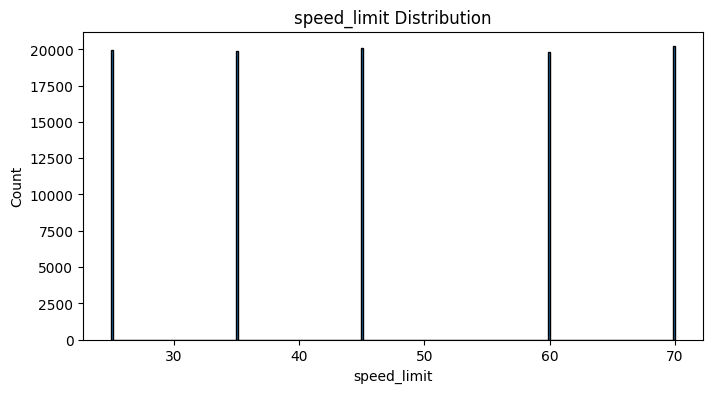

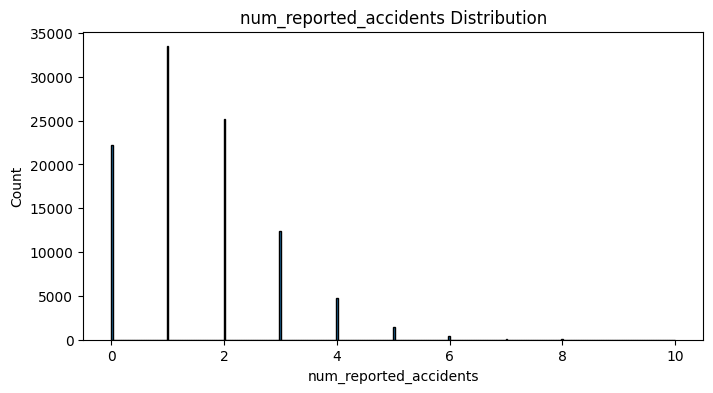

In [30]:
plot_feature_distributions(original_df, o_num)

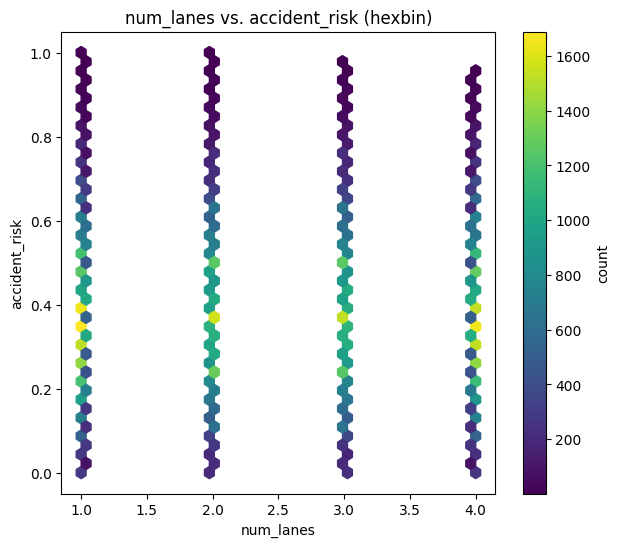

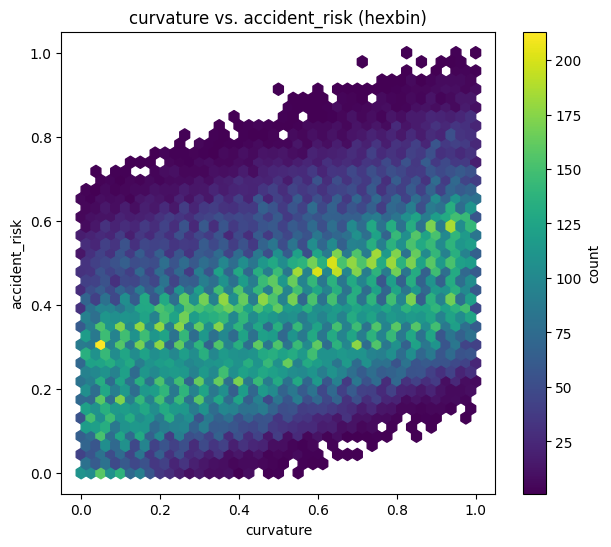

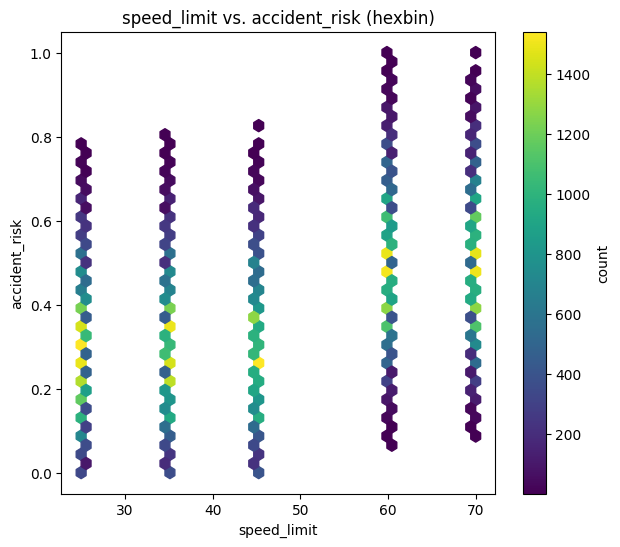

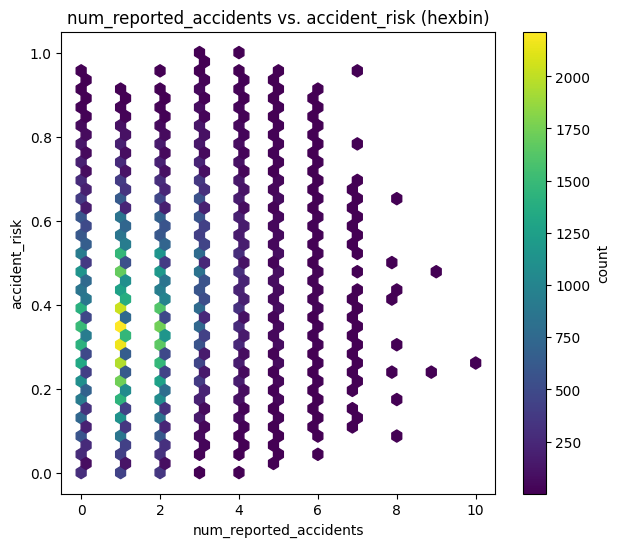

In [31]:
plot_feature_target_relationships(original_df, o_target, o_num)

In [32]:
plot_missing_values(original_df)

No missing values detected.


In [33]:
show_relationship_rank(original_df)

([('accident_risk', 'speed_limit', 0.4935596349848467),
  ('accident_risk', 'curvature', 0.47961400147498273),
  ('accident_risk', 'num_reported_accidents', 0.17122752606709757),
  ('num_lanes', 'num_reported_accidents', 0.0036797912959047234),
  ('curvature', 'num_lanes', 0.002668672685119269),
  ('accident_risk', 'num_lanes', 0.00233485132257143),
  ('num_reported_accidents', 'speed_limit', 0.002246651237306813),
  ('curvature', 'num_reported_accidents', 0.0017394819246903935),
  ('curvature', 'speed_limit', 0.001402908279394156),
  ('num_lanes', 'speed_limit', 0.0007635057471387027)],
 [('accident_risk', 'speed_limit', 0.47553817064376985),
  ('accident_risk', 'curvature', 0.4694321426363731),
  ('accident_risk', 'num_reported_accidents', 0.14849663923552892),
  ('num_lanes', 'num_reported_accidents', 0.003982123295701818),
  ('curvature', 'num_lanes', 0.002658794371958894),
  ('curvature', 'num_reported_accidents', 0.001886579178332558),
  ('accident_risk', 'num_lanes', 0.001585588

## Dataset Comparison Report

**TODO**

## Feature Engineering

**TODO**

## Prepare Submission

In [34]:
# Build submission

# TODO